Customer Churn Prediction with Random Forest
Overview
This project focuses on predicting customer churn for a telecom company using a dataset that includes customer demographics and account information. The goal is to predict whether a customer will churn (leave) based on various features, such as tenure, monthly charges, contract type, and more. The project includes data preprocessing, exploratory data analysis (EDA), feature scaling, model training, and performance evaluation.

In [20]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score,
    roc_curve, f1_score, recall_score, precision_score
)
from sklearn.calibration import calibration_curve
from scipy.stats import zscore, chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant



Dataset Overview
The dataset is sourced from the WA_Fn-UseC_-Telco-Customer-Churn.csv, with the following key columns:
* customerID: Unique customer identifier
* Churn: Target variable indicating whether the customer churned (1) or not (0)
* Features: Demographic and account-related attributes like gender, tenure, monthly charges, total charges, contract type, and more.

In [21]:
# Load dataset
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Data Overview
print(df.info())
print(df.isnull().sum())
print(df.describe())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
Data Preprocessing
1. Load and Inspect Data: Load the dataset and inspect basic information such as missing values and descriptive statistics.
2. Handle Missing Data: Missing values in the TotalCharges column are filled with 0, and any non-numeric values are converted.
3. Encode Categorical Variables: Label encoding is applied to all categorical columns except for customerID and Churn.


In [ ]:
Exploratory Data Analysis (EDA)
1. Churn Distribution: A count plot is used to visualize the distribution of churned vs. non-churned customers.
2. Monthly Charges vs. Churn: A boxplot visualizes how monthly charges vary with churn.
3. Correlation Matrix: A heatmap shows the correlation between numerical features.
4. Gender and Churn: A pie chart visualizes the proportion of churn by gender.
5. Senior Citizen Status and Churn: A pie chart visualizes the churn proportion for senior citizens vs. non-senior citizens.
6. Churn Count by Contract Type: A grouped bar chart visualizes churn count by contract type.
7. Chi-Square Test: A chi-square test is conducted between churn and contract type to check for statistical significance.

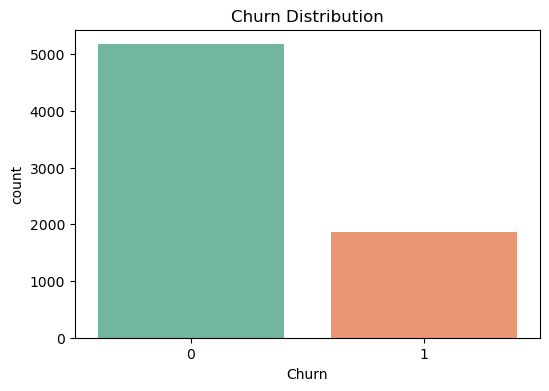

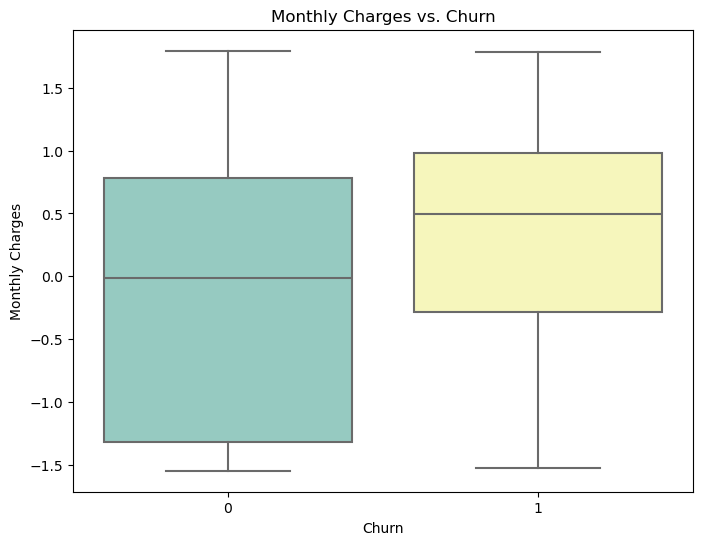

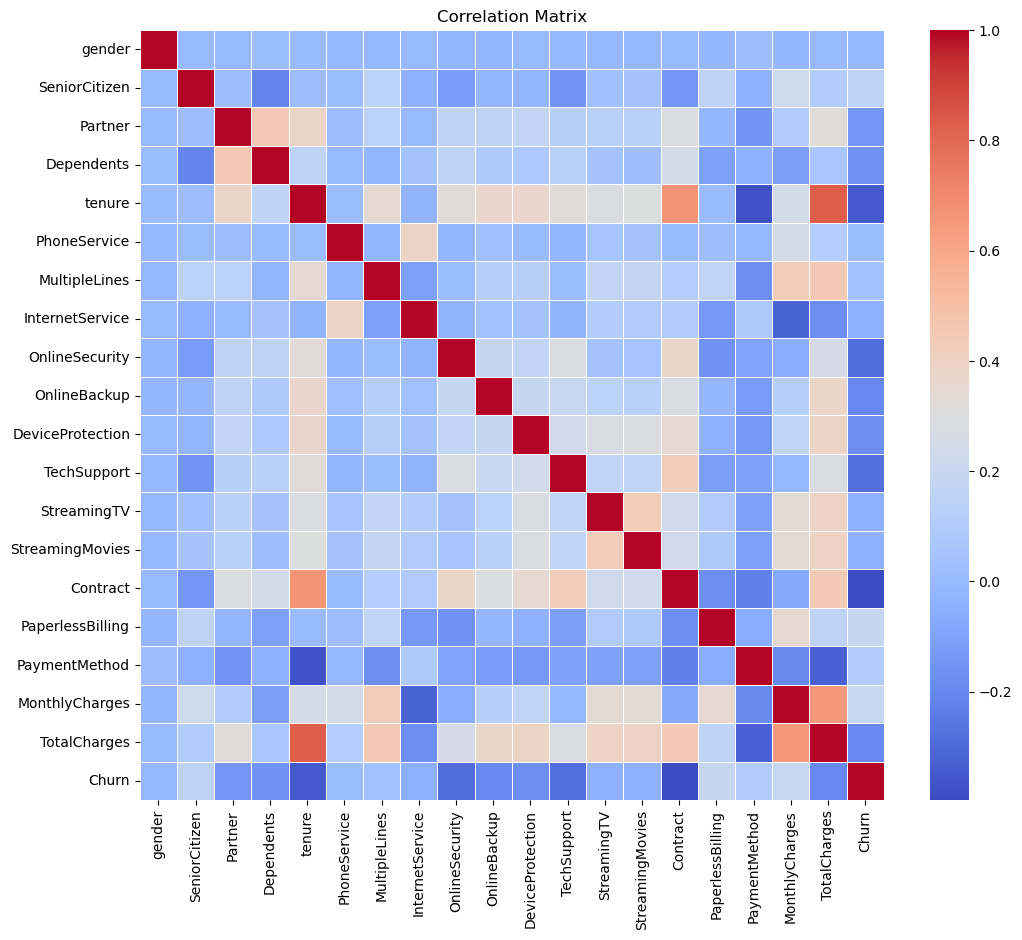

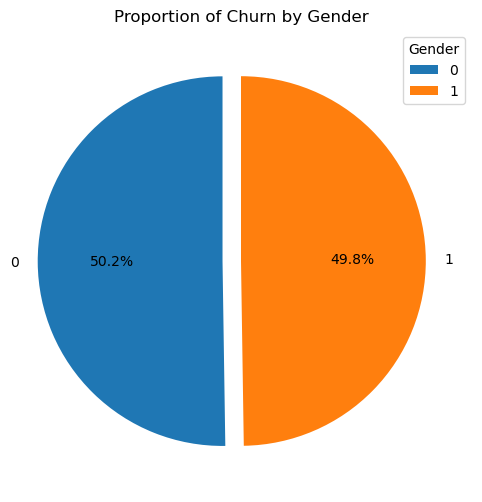

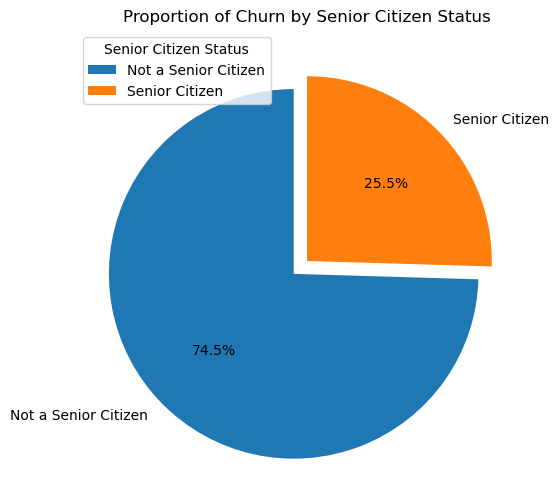

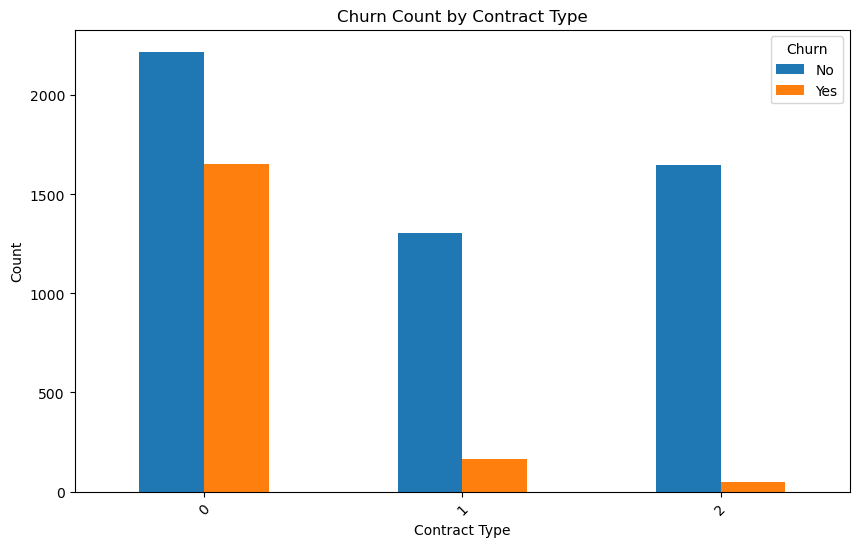

Chi-square Statistic: 1184.60
Degrees of Freedom: 2
p-value: 0.0000


In [28]:
# Convert 'TotalCharges' to numeric and handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# Encode categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if col != 'customerID':
        df[col] = LabelEncoder().fit_transform(df[col])

# Churn Distribution Plot
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn', palette='Set2')
plt.title('Churn Distribution')
plt.show()

# Monthly Charges vs. Churn
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette='Set3')
plt.title('Monthly Charges vs. Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()

# Correlation Matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Visualizations: Gender and Churn
gender_churn_totals = df[df['Churn'] == 1]['gender'].value_counts()
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    gender_churn_totals, autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'], startangle=90, explode=(0.1, 0),
    labels=gender_churn_totals.index
)
plt.legend(wedges, gender_churn_totals.index, title="Gender", loc="best")
plt.title('Proportion of Churn by Gender')
plt.ylabel('')
plt.show()

# Proportion of Churn by Senior Citizen Status
df['SeniorCitizenLabel'] = df['SeniorCitizen'].map({0: 'Not a Senior Citizen', 1: 'Senior Citizen'})
senior_churn_totals = df[df['Churn'] == 1]['SeniorCitizenLabel'].value_counts()
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    senior_churn_totals, autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'], startangle=90, explode=(0.1, 0),
    labels=senior_churn_totals.index
)
plt.legend(wedges, senior_churn_totals.index, title="Senior Citizen Status", loc="best")
plt.title('Proportion of Churn by Senior Citizen Status')
plt.ylabel('')
plt.show()
df = df.drop('SeniorCitizenLabel', axis=1)

# Churn Count by Contract Type (Grouped Bar Chart)
contract_churn_counts = df.groupby(['Contract', 'Churn']).size().unstack()
contract_churn_counts.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Churn Count by Contract Type')
plt.ylabel('Count')
plt.xlabel('Contract Type')
plt.xticks(rotation=45)
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

# Chi-Square Test for Churn and Contract Type
contingency_table = pd.crosstab(df['Churn'], df['Contract'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"p-value: {p:.4f}")


Feature Scaling and Model Training
1. Feature Scaling: StandardScaler is applied to numerical features (tenure, MonthlyCharges, TotalCharges).
2. Train-Test Split: The data is split into training (80%) and testing (20%) sets.
3. Random Forest Classifier: A Random Forest model is trained on the training set and evaluated on the test set.

In [29]:
# Feature Scaling
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

# Splitting Dataset
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models and Evaluation
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]


Model Evaluation
1. Confusion Matrix: Visualizes the performance of the Random Forest model.
2. Feature Importance: Displays the importance of each feature in predicting churn using the Random Forest model.
3. ROC-AUC Curve: Plots the ROC curve for the Random Forest model to assess its discriminatory ability.
4. Calibration Curve: Plots the calibration curve to evaluate how well the predicted probabilities match the true outcomes.

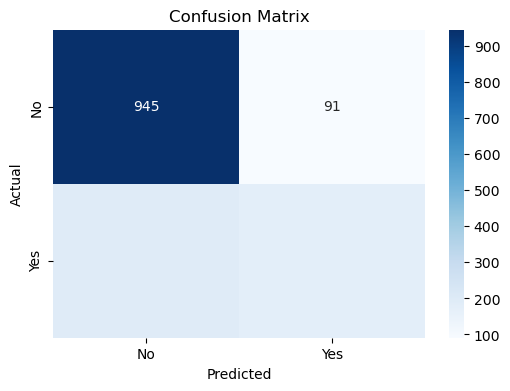

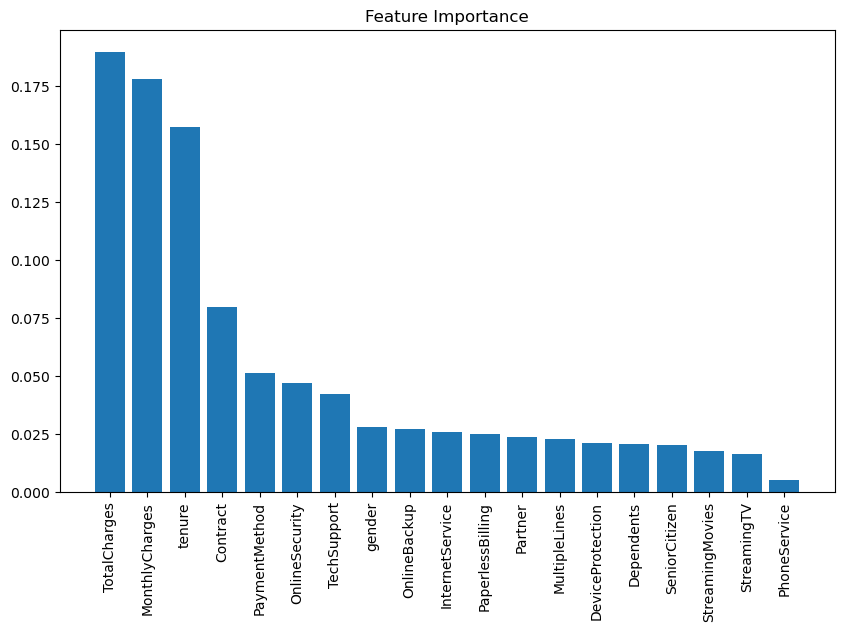

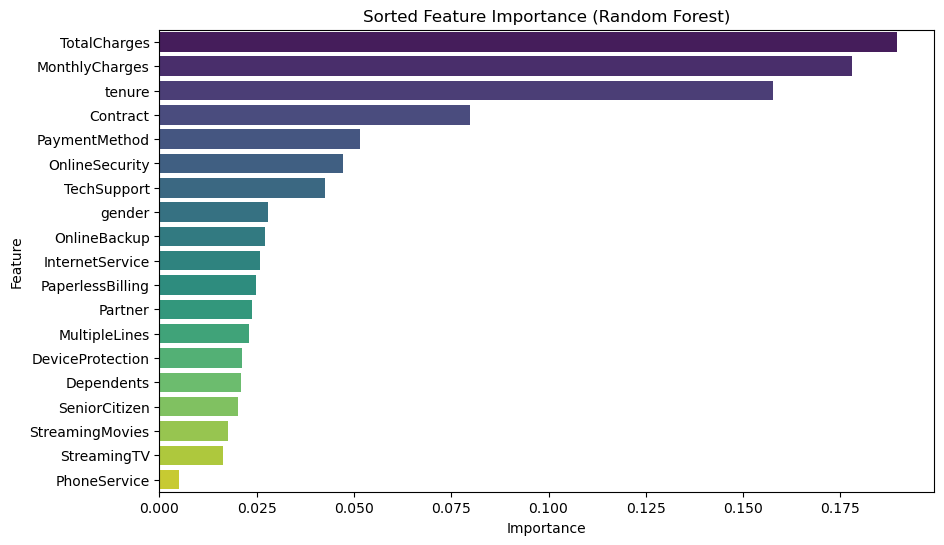

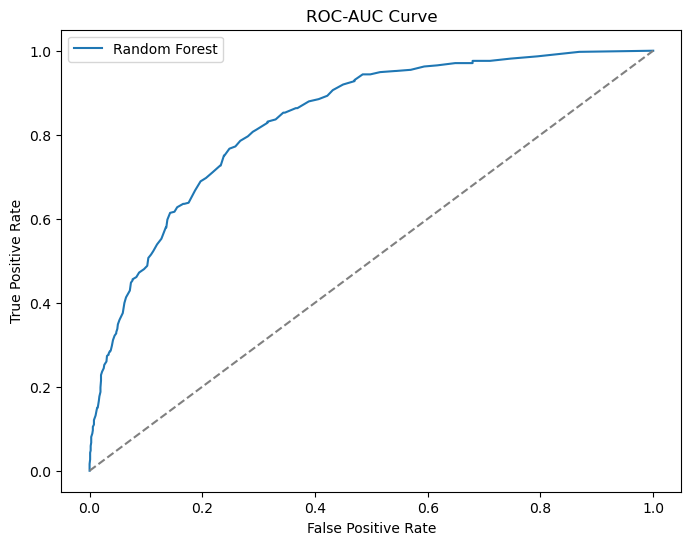

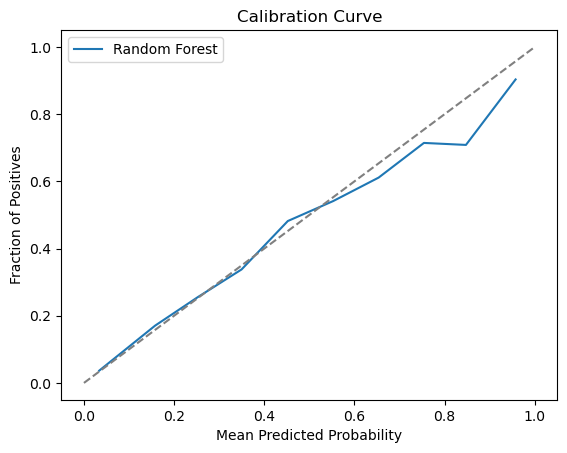

                 Model  Accuracy  F1-Score    Recall  Precision
0  Logistic Regression  0.816891  0.627168  0.581769   0.680251
1        Random Forest  0.795600  0.550000  0.471850   0.659176


In [30]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.title("Feature Importance")
plt.show()

# Sorted Feature Importance
sorted_importance = pd.DataFrame({
    'Feature': [X.columns[i] for i in indices],
    'Importance': importances[indices]
})

# Plot Sorted Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=sorted_importance, palette='viridis')
plt.title('Sorted Feature Importance (Random Forest)')
plt.show()

# ROC-AUC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()

# Calibration Curve
fraction_pos_rf, mean_pred_rf = calibration_curve(y_test, rf_prob, n_bins=10)
plt.plot(mean_pred_rf, fraction_pos_rf, label="Random Forest")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.legend()
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.show()

# Model Performance Evaluation Summary
results = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, LogisticRegression().fit(X_train, y_train).predict(X_test)),
        accuracy_score(y_test, rf_model.predict(X_test))
    ],
    "F1-Score": [
        f1_score(y_test, LogisticRegression().fit(X_train, y_train).predict(X_test)),
        f1_score(y_test, rf_model.predict(X_test))
    ],
    "Recall": [
        recall_score(y_test, LogisticRegression().fit(X_train, y_train).predict(X_test)),
        recall_score(y_test, rf_model.predict(X_test))
    ],
    "Precision": [
        precision_score(y_test, LogisticRegression().fit(X_train, y_train).predict(X_test)),
        precision_score(y_test, rf_model.predict(X_test))
    ]
}

results_df = pd.DataFrame(results)
print(results_df)



Performance Evaluation
Here are the evaluation metrics for both Logistic Regression and Random Forest models:
Model Performance Comparison

Model	Accuracy	F1-Score	Recall	Precision
Logistic Regression	0.8169	0.6272	0.5818	0.6803
Random Forest	0.7956	0.55	0.4719	0.6592

Logistic Regression Detailed Metrics:
* Accuracy: 0.8211
* Precision: 0.69 (Class 1), 0.86 (Class 0)
* Recall: 0.60 (Class 1), 0.90 (Class 0)
* F1-Score: 0.64 (Class 1), 0.88 (Class 0)
* ROC-AUC: 0.8622
Random Forest Detailed Metrics:
* Accuracy: 0.7949
* Precision: 0.65 (Class 1), 0.83 (Class 0)
* Recall: 0.49 (Class 1), 0.90 (Class 0)
* F1-Score: 0.56 (Class 1), 0.87 (Class 0)
* Macro Average F1-Score: 0.71
* Weighted Average F1-Score: 0.78

Statistical Analysis
Chi-Square Test between Churn and Contract Type:
* Chi-Square Statistic: 1184.60
* Degrees of Freedom: 2
* p-value: 0.0000 (indicating a significant association between churn and contract type)
Feature Importance (Random Forest):
* Top Features:
    * TotalCharges: 0.1834
    * MonthlyCharges: 0.1623
    * Tenure: 0.1436
* Other Notable Features:
    * Contract_0: 0.0623
    * OnlineSecurity: 0.0431
    * TechSupport: 0.0376

Key Insights
* Model Performance: Logistic Regression outperforms Random Forest in accuracy, F1-score, and recall for churn prediction.
* Feature Importance: TotalCharges, MonthlyCharges, and Tenure are the most critical predictors of churn in the Random Forest model.
* Chi-Square Test: There is a significant statistical association between Contract Type and churn, suggesting that the type of contract is an important factor in predicting churn.








Conclusion
The project successfully demonstrated how machine learning techniques, particularly Random Forest and Logistic Regression, can be used to predict customer churn. Logistic Regression performed slightly better overall, but further model tuning and feature engineering could enhance the Random Forest model's ability to predict churn more accurately.